In [35]:
import numpy
import pandas
import calendar
import os
import seaborn as sns

from keras.models import Sequential
from keras.layers import Dense,Dropout
from keras.optimizers import SGD
from keras.layers import BatchNormalization

from keras.wrappers.scikit_learn import KerasRegressor
from keras.callbacks import EarlyStopping
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline
from keras import regularizers
from keras.constraints import maxnorm



In [36]:
# to make this notebook's output stable across runs
numpy.random.seed(7)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "graphs")

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

# Ignore useless warnings (see SciPy issue #5998)
import warnings
warnings.filterwarnings(action="ignore", message="^internal gelsd")

In [37]:
# load dataset
original_data = pandas.read_csv(".//Data//TrainingData1.csv")

original_data.shape


(2120, 7)

In [38]:
# Data to be used for EDA (Exploratory Data Analytics)
EDA_data = original_data.copy()
EDA_data.head()

,Month,Day,WeekDay,Holiday,HolidayWeightage,NearHoliday,AttendancePercentage
0,1,12,3,0,0,0,88.412943
1,11,29,4,0,0,0,83.279077
2,5,18,6,0,0,0,82.807641
3,7,1,5,0,0,0,79.008746
4,3,9,6,0,0,0,84.423019


Saving figure Monthly_Average_Attendnance


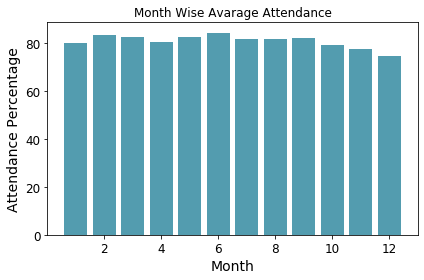

In [39]:
idx = pandas.Int64Index([1,2,3,4,5,6,7,8,9,10,11,12])
attendanceByMonth = pandas.DataFrame(original_data.groupby(by="Month",as_index=False)['AttendancePercentage'].mean())
x_eda_data = attendanceByMonth["Month"]
y_eda_data = attendanceByMonth["AttendancePercentage"]

_, ax = plt.subplots()
# Draw bars, position them in the center of the tick mark on the x-axis
ax.bar(x_eda_data, y_eda_data, color = '#539caf', align = 'center')
# Draw error bars to show standard deviation, set ls to 'none'
# to remove line between points
ax.errorbar(x_eda_data, y_eda_data,  color = '#297083', ls = 'none', lw = 2, capthick = 2)
ax.set_ylabel('Attendance Percentage')
ax.set_xlabel('Month')
ax.set_title('Month Wise Avarage Attendance')
save_fig("Monthly_Average_Attendnance")


Saving figure Attendance_Percentage_Density_Across_Months


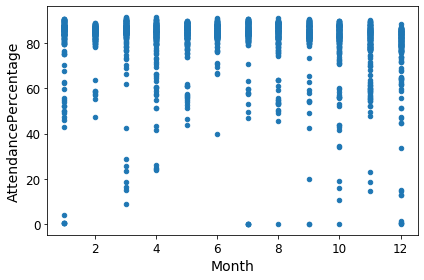

In [40]:
#Attendance Percentage Density acroos Months
EDA_data.plot(kind="scatter",x="Month",y="AttendancePercentage")
save_fig("Attendance_Percentage_Density_Across_Months")

Saving figure Attendance_Percentage_Density_Week_Days


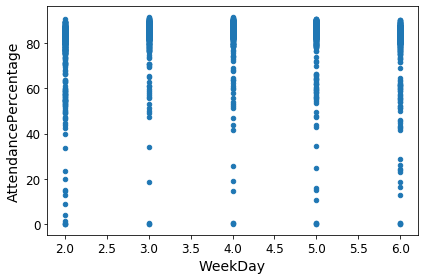

In [41]:
#Attendance Percentage Density across Week Days
EDA_data.plot(kind="scatter",x="WeekDay",y="AttendancePercentage",norm="Normalize")
save_fig("Attendance_Percentage_Density_Week_Days")

Saving figure Attendance_Percentage_Density_Month_Days


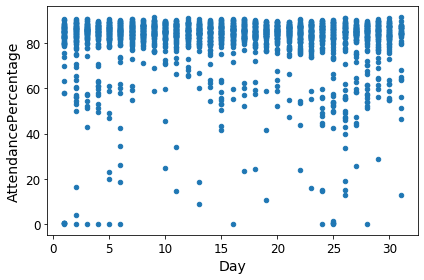

In [42]:
#Attendance Percentage Density across Month Days
EDA_data.plot(kind="scatter",x="Day",y="AttendancePercentage",norm="Normalize")
save_fig("Attendance_Percentage_Density_Month_Days")

In [43]:

corr_matrix = EDA_data.corr()

corr_matrix

,Month,Day,WeekDay,Holiday,HolidayWeightage,NearHoliday,AttendancePercentage
Month,1.000000,0.009515,0.002001,0.024241,-0.000417,-0.007507,-0.118926
Day,0.009515,1.000000,-0.005291,-0.012120,0.000587,0.007803,-0.030237
WeekDay,0.002001,-0.005291,1.000000,-0.147806,-0.034138,-0.158488,0.041402
Holiday,0.024241,-0.012120,-0.147806,1.000000,0.635717,0.447724,-0.557190
HolidayWeightage,-0.000417,0.000587,-0.034138,0.635717,1.000000,0.284626,-0.762410
NearHoliday,-0.007507,0.007803,-0.158488,0.447724,0.284626,1.000000,-0.303478
AttendancePercentage,-0.118926,-0.030237,0.041402,-0.557190,-0.762410,-0.303478,1.000000


In [44]:
# split into input (train_X) and output (train_Y) variables
train_X = original_data.drop(columns='AttendancePercentage')
train_X.head()

,Month,Day,WeekDay,Holiday,HolidayWeightage,NearHoliday
0,1,12,3,0,0,0
1,11,29,4,0,0,0
2,5,18,6,0,0,0
3,7,1,5,0,0,0
4,3,9,6,0,0,0


In [45]:
train_Y = original_data[['AttendancePercentage']]
train_Y.head()

,AttendancePercentage
0,88.412943
1,83.279077
2,82.807641
3,79.008746
4,84.423019


In [46]:
# from sklearn.pipeline import Pipeline
# from sklearn.preprocessing import StandardScaler
# from sklearn.impute import SimpleImputer


In [47]:
# define base model
def baseline_model():
    # create model
    model = Sequential()
    #kernel_initilaizer specifies how weights areinitalized.
    #model.add(Dense(12, input_dim=6, kernel_initializer='normal', activation='relu'))
    model.add(Dense(100, input_dim=6, activation='relu'))
    #Activation functions tell us about the nonlinear relationships.
    #No activation function is used for the output layer because it is a regression problem 
    #and we are interested in predicting numerical values directly without transform.
    model.add(Dense(1, kernel_initializer='normal'))
    #Other types of layers could be Convolutional and Recurrent.
    # Compile model
    model.compile(loss='mean_squared_error', optimizer='adam')
    #The optimizer controls the learning rate.
    return model

In [48]:
seed = 7
numpy.random.seed(seed)

In [49]:
# fix random seed for reproducibility

# evaluate model with standardized dataset
estimator = KerasRegressor(build_fn=baseline_model, epochs=100, batch_size=5, verbose=0)

In [50]:
kfold = KFold(n_splits=10, random_state=seed)
results = cross_val_score(estimator, train_X, train_Y, cv=kfold)
print("Results: %.2f (%.2f) MSE" % (results.mean(), results.std()))

C:\ProgramData\Anaconda3\envs\tefenv\lib\site-packages\sklearn\model_selection\_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


Results: -70.39 (29.68) MSE


In [51]:
# evaluate model with standardized dataset
numpy.random.seed(seed)
estimators = []
estimators.append(('standardize', MinMaxScaler()))
# The Keras wrapper object for use in scikit-learn 
# as a regression estimator is called KerasRegressor
estimators.append(('mlp', KerasRegressor(build_fn=baseline_model, epochs=50, batch_size=5, verbose=0)))
pipeline = Pipeline(estimators)
kfold = KFold(n_splits=10, random_state=seed)
results = cross_val_score(pipeline, train_X, train_Y, cv=kfold)
print("Standardized: %.2f (%.2f) MSE" % (results.mean(), results.std()))

Standardized: -69.79 (29.48) MSE


In [52]:
#Let's try larger network with L2 regularization
# define the model
def larger_model():
# create model
    model = Sequential()
    model.add(Dense(60, input_dim=6, kernel_initializer='normal', activation='relu',kernel_regularizer=regularizers.l2(0.06)))    
    
    model.add(Dense(18, kernel_initializer='normal', activation='relu',kernel_regularizer=regularizers.l2(0.06)))
    model.add(Dense(12, kernel_initializer='normal', activation='relu',kernel_regularizer=regularizers.l2(0.06)))
    model.add(Dense(6, kernel_initializer='normal', activation='relu',kernel_regularizer=regularizers.l2(0.06)))    
    model.add(Dense(1, kernel_initializer='normal'))
    # Compile model
    model.compile(loss='mean_squared_error', optimizer='adam')
    
    
    return model

In [53]:
#Let's try larger network with DROP OUT Regularization
# define the model
def larger_DO_LR_model():
# create model
    model = Sequential()
    
    model.add(Dense(64, input_dim=6, kernel_initializer='normal', activation='relu',kernel_constraint=maxnorm(3)))    
    model.add(Dropout(0.1))
    model.add(BatchNormalization(momentum=0.99))
    model.add(Dense(32, kernel_initializer='normal', activation='relu',kernel_constraint=maxnorm(3)))        
    
    
    
    
    model.add(Dropout(0.5))
    
    model.add(Dense(1, kernel_initializer='normal'))
    # Compile model
    # Using Learning Rate OPtimizer
    # opt = SGD(lr=0.01,momentum=0.99)
    #model.compile(loss='mean_squared_error', optimizer='adam')
    model.compile(loss='mean_squared_error', optimizer='adam')
    
    
    return model

In [54]:
numpy.random.seed(seed)
estimators = []

estimators.append(('standardize', StandardScaler()))
estimators.append(('mlp', KerasRegressor(build_fn=larger_DO_LR_model, epochs=150, batch_size=20, verbose=0)))
pipeline = Pipeline(estimators)
kfold = KFold(n_splits=10)
results = cross_val_score(pipeline, train_X, train_Y, cv=kfold)
print("Larger: %.2f (%.2f) MSE" % (results.mean(), results.std()))


Larger: -69.11 (29.97) MSE


In [55]:
print(results)

[ -50.67389862  -22.98005376  -92.07389504  -36.62782561  -40.09469471
  -60.2625044  -117.66486024 -104.3606973   -80.19040424  -86.16264933]


In [56]:
#Let's try larger network with DROP OUT Regularization
# define the model
def larger_DO_model():
# create model
    model = Sequential()
    
    model.add(Dense(128, input_dim=6, kernel_initializer='normal', activation='relu',kernel_constraint=maxnorm(3)))    
    model.add(Dropout(0.1))
    model.add(BatchNormalization(momentum=0.99))
    model.add(Dense(64, kernel_initializer='normal', activation='relu',kernel_constraint=maxnorm(3)))        
    model.add(Dropout(0.5))
    model.add(Dense(1, kernel_initializer='normal'))
    # Compile model
    model.compile(loss='mean_squared_error', optimizer='adam')
    
    
    return model

In [57]:
numpy.random.seed(seed)
estimators = []
estimators.append(('standardize', MinMaxScaler()))
estimators.append(('mlp', KerasRegressor(build_fn=larger_DO_model, epochs=150, batch_size=128, verbose=0)))
pipeline = Pipeline(estimators)
kfold = KFold(n_splits=10, random_state=seed, shuffle=True)
results = cross_val_score(pipeline, train_X, train_Y, cv=kfold)
print("Larger: %.2f (%.2f) MSE" % (results.mean(), results.std()))

Larger: -78.06 (33.50) MSE


In [58]:
#Evaluate a Wider Network Topology

In [59]:
# define wider model
def wider_model():
    # create model
    model = Sequential()
    model.add(Dense(150,input_dim=6, kernel_initializer='normal', activation='relu'))
    
    model.add(Dense(1, kernel_initializer='normal'))
    # Compile model
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model

In [60]:
numpy.random.seed(seed)
estimators = []
estimators.append(('standardize', StandardScaler()))
estimators.append(('mlp', KerasRegressor(build_fn=wider_model, epochs=100, batch_size=150, verbose=0)))
pipeline = Pipeline(estimators)
kfold = KFold(n_splits=10, random_state=seed)
results = cross_val_score(pipeline, train_X, train_Y, cv=kfold)
print("Wider: %.2f (%.2f) MSE" % (results.mean(), results.std()))

C:\ProgramData\Anaconda3\envs\tefenv\lib\site-packages\sklearn\model_selection\_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


Wider: -85.70 (32.44) MSE


In [61]:
from numpy import array
# define wider model
# create model
model = larger_DO_LR_model()
#set early stopping monitor so the model stops training when it won't improve anymore
early_stopping_monitor = EarlyStopping(patience=3)

# Batch size should be in the multiple of 2 e.g 64, 128, 256 etc
model.fit(train_X,train_Y,validation_split=0.1, epochs=100,batch_size=64)
# epochs represent the number of times, model will cycle through the data. 
# More the number of cycles, results are likely to improve. To monitor this,we can use early stopping.




    

Train on 1908 samples, validate on 212 samples
Epoch 1/100
1908/1908 [==============================] - 0s 158us/step - loss: 6638.7956 - val_loss: 6548.3813
Epoch 2/100
1908/1908 [==============================] - 0s 26us/step - loss: 6388.2117 - val_loss: 6278.0600
Epoch 3/100
1908/1908 [==============================] - 0s 26us/step - loss: 5742.4876 - val_loss: 5697.5480
Epoch 4/100
1908/1908 [==============================] - 0s 24us/step - loss: 4646.7709 - val_loss: 4342.0795
Epoch 5/100
1908/1908 [==============================] - 0s 22us/step - loss: 3388.5970 - val_loss: 3143.4350
Epoch 6/100
1908/1908 [==============================] - 0s 23us/step - loss: 2371.3830 - val_loss: 2213.2216
Epoch 7/100
1908/1908 [==============================] - 0s 23us/step - loss: 1733.5514 - val_loss: 1621.1976
Epoch 8/100
1908/1908 [==============================] - 0s 23us/step - loss: 1390.0452 - val_loss: 1361.3292
Epoch 9/100
1908/1908 [==============================] - 0s 27us/step - 

Epoch 76/100
1908/1908 [==============================] - 0s 25us/step - loss: 283.8802 - val_loss: 94.9212
Epoch 77/100
1908/1908 [==============================] - 0s 25us/step - loss: 287.0893 - val_loss: 95.8735
Epoch 78/100
1908/1908 [==============================] - 0s 25us/step - loss: 277.6789 - val_loss: 93.5560
Epoch 79/100
1908/1908 [==============================] - 0s 25us/step - loss: 280.9948 - val_loss: 95.7077
Epoch 80/100
1908/1908 [==============================] - 0s 26us/step - loss: 301.1517 - val_loss: 98.0869
Epoch 81/100
1908/1908 [==============================] - 0s 25us/step - loss: 281.4240 - val_loss: 91.5229
Epoch 82/100
1908/1908 [==============================] - 0s 25us/step - loss: 261.9522 - val_loss: 90.6313
Epoch 83/100
1908/1908 [==============================] - 0s 26us/step - loss: 276.8507 - val_loss: 91.1726
Epoch 84/100
1908/1908 [==============================] - 0s 25us/step - loss: 269.0776 - val_loss: 95.5447
Epoch 85/100
1908/1908 [====

In [62]:

# Number of employees expected to attend office on a normal day
# Parameters: 
    #Month of year : 5 (May)
    # Day of Month : 17 , 
    # Day of Week : 3 (Tuesday),
    # Is Holiday? : 0 (No)
    # Holiday weightage: 0 (As this is not a holiday)
    # Near holiday: 0 (No)

train_Xnew = array([[5,17,3,0,0,0]])

ynew = model.predict(train_Xnew)
print("Percentage of employees expected to attend office: %s" % (ynew[0]))


Percentage of employees expected to attend office: [81.51985]


In [63]:
# Number of employees expected to attend office on a Holiday for 30% employees
# Parameters: 
    #Month of year : 5 (May)
    # Day of Month : 19 , 
    # Day of Week : 6 (Friday),
    # Is Holiday? : 1 Yes
    # Holiday weightage: 30 
    # Near holiday: 1 Yes

train_Xnew = array([[5,19,6,1,30,1]])

ynew = model.predict(train_Xnew)
print("Percentage of employees expected to attend office: %s" % (ynew[0]))


Percentage of employees expected to attend office: [52.832874]


In [64]:
# Number of employees expected to attend office on a Holiday for 80% employees
# Parameters: 
    #Month of year : 10 (October)
    # Day of Month : 18 , 
    # Day of Week : 4 (Wednesday),
    # Is Holiday? : 1 (Yes)
    # Holiday weightage: 80 
    # Near holiday: 1 (Yes)

train_Xnew = array([[10,18,4,1,80,1]])

ynew = model.predict(train_Xnew)
print("Percentage of employees expected to attend office: %s" % (ynew[0]))

Percentage of employees expected to attend office: [7.445273]


In [65]:
# Number of employees expected to attend office on a day in December end on Normal day
# Parameters: 
    #Month of year : 12 (December)
    # Day of Month : 4 , 
    # Day of Week : 2 (Monday),
    # Is Holiday? : 0 (Yes)
    # Holiday weightage: 0 
    # Near holiday: 1 (Yes)

train_Xnew = array([[12,5,2,1,20,1]])

ynew = model.predict(train_Xnew)
print("Percentage of employees expected to attend office: %s" % (ynew[0]))

Percentage of employees expected to attend office: [57.138332]
